In [1]:
import os
import sys
import warnings

warnings.filterwarnings('ignore')

import cv2
import mmcv
import mmengine
import numpy as np
import torch
from gpat.utils.files import FileName
from gpat.utils.utils import calculate_iou, get_file_name
from mmdet.apis import inference_detector, init_detector

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.apis import inference_top_down_pose_model
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmpose.evaluation.functional import nms
from mmpose.utils import adapt_mmdet_pipeline

In [2]:
video_path = "/home/osamu/gpat-horse/GPAT/horse.mp4"

cap = cv2.VideoCapture(video_path)
img = cap.read()[1]

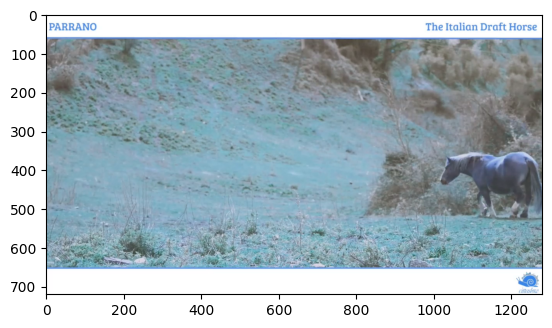

In [3]:
import matplotlib.pyplot as plt

plt.imshow(img)
plt.show()

In [4]:
det_model = "/home/osamu/gpat-horse/GPAT/models/rtmdet_l_8xb32-300e_coco.py"
det_checkpoint = "/home/osamu/gpat-horse/GPAT/models/rtmdet_l_8xb32-300e_coco_20220719_112030-5a0be7c4.pth"

In [5]:
detector = init_detector(det_model, det_checkpoint, device="cuda")
detector.cfg = adapt_mmdet_pipeline(detector.cfg)

Loads checkpoint by local backend from path: /home/osamu/gpat-horse/GPAT/models/rtmdet_l_8xb32-300e_coco_20220719_112030-5a0be7c4.pth
The model and loaded state dict do not match exactly

unexpected key in source state_dict: data_preprocessor.mean, data_preprocessor.std



In [6]:
det_result = inference_detector(detector, img)
pred_instance = det_result.pred_instances.cpu().numpy()

In [7]:
det_cat_id = 17
bbox_thr = 0.3
nms_thr = 0.5

In [8]:
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == det_cat_id, pred_instance.scores > bbox_thr)]
bboxes = bboxes[nms(bboxes, nms_thr), :4]

In [9]:
bboxes

array([[1016.35693,  354.0086 , 1280.     ,  527.8313 ]], dtype=float32)

In [9]:
radius: int = 5
alpha: float = 0.8
thickness: int = 1

In [10]:
pose_model = "/home/osamu/gpat-horse/GPAT/models/td-hm_hrnet-w48_8xb64-210e_animalpose-256x256.py"
pose_checkpoint = "/home/osamu/gpat-horse/GPAT/models/hrnet_w48_animalpose_256x256-34644726_20210426.pth"

In [11]:
pose_estimator = init_pose_estimator(pose_model, pose_checkpoint, device='cuda')
pose_estimator.cfg.visualizer.radius = radius
pose_estimator.cfg.visualizer.alpha = alpha
pose_estimator.cfg.visualizer.line_width = thickness

Loads checkpoint by local backend from path: /home/osamu/gpat-horse/GPAT/models/hrnet_w48_animalpose_256x256-34644726_20210426.pth


In [12]:
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

In [13]:
pose_results = inference_topdown(pose_estimator, img, bboxes)

In [14]:
data_samples = merge_data_samples(pose_results)

In [15]:
visualizer.add_datasample(
    'result',
    img,
    data_sample=data_samples,
    draw_gt=False,
    )

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [252, 254, 255],
        [252, 254, 255],
        [252, 254, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [252, 254, 255],
        [252, 254, 255],
        [252, 254, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [252, 254, 255],
        [252, 254, 255],
        [252, 254, 255]]

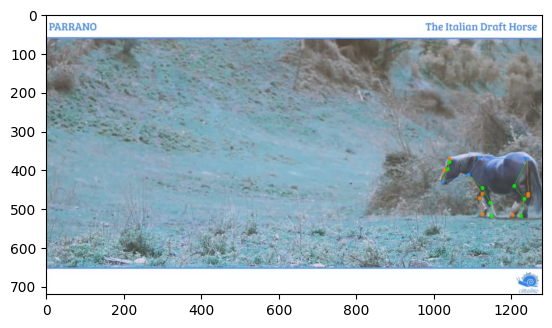

In [16]:
plt.imshow(visualizer.get_image())
plt.show()